## Demand Prediction Model using Time Series

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_initial = pd.read_pickle('./DemandDataFile', compression='infer')
df_region = pd.read_pickle('./RegionDataFile', compression='infer')
df_initial = pd.merge(df_initial, df_region, how='inner', right_on=['CITY_NAME'], left_on=['CITY'])
df_initial = df_initial.drop(['CITY_NAME'], axis=1)
df_initial = df_initial[~df_initial['PRODUCT_NAME'].str.contains("Small Flyers|Large Flyers|Meter Bubble Wrap|Bundle of 50 Boxes", na=False)]

In [3]:
df_initial.rename(columns = {'ORDER_DATE':'DATE'},inplace = True)

In [4]:
df_initial.head()

,COD_ORDER_NR,SKU,DATE,CATEGORY_LEVEL_1,CATEGORY_LEVEL_2,CATEGORY_LEVEL_3,CATEGORY_LEVEL_4,PRODUCT_NAME,BRAND_NAME,UNIT_PRICE,...,PRODUCT_WEIGHT,CUSTOMER_DEVICE,PAYMENT_OPTION,CTV,Gender,CITY,Voucher,MV,Quantity,REGION_NAME
0,305332633,MA305FA1CS0BSNAFAMZ,2018-03-06,Women's Fashion,Women's Clothing,Lingerie & Sleepwear,Shapewear,Beige Polyester Body Shaper For Women,Mardaz,934.15,...,0.5,Android,COD,1537757,male,Karachi,NaN,934.15,1,Sindh
2,345719922,BO498EL103VHSNAFAMZ,2018-05-06,Phones & Tablets,Phone & Tablet Accessories,Cases & Covers,Android Tablets,Universal 9 Inch Tablet Cover - Brown,Boorak,380.00,...,0.5,Android,COD,1727270,female,Karachi,NaN,380.00,1,Sindh
3,305857193,FR892HB0AR6BQNAFAMZ,2018-02-10,Beauty & Health,Skin Care,Face Masks & Packs,N/A,Facial Purifying Clay Mask Clean Pores & Sooth...,Freeman,405.10,...,0.2,Mobile (Theme),COD,1457029,N/A,Karachi,NaN,405.10,1,Sindh
4,309725313,UM501EL188VKMNAFAMZ,2018-03-04,Phones & Tablets,Phone & Tablet Accessories,Other Accessories,Others,Universal Flexible Mobile Stand - Purple,UMW,137.00,...,0.2,Android,COD,1532585,male,Karachi,NaN,274.00,2,Sindh
5,357171122,NA406FA1DD3G4NAFAMZ,2018-05-22,Men's Fashion,Men's Accessories,Jewellery,Bracelets,Silver Chain Men Bracelet,Naya Rung,145.00,...,0.2,Android,COD,1781749,male,Karachi,13.61,131.39,1,Sindh


In [5]:
df_weights = pd.read_csv('./ProductWeights.csv')
df_weights.drop_duplicates(subset=['COD_SKU_CONFIG'],inplace =True)

df_productReviews = pd.read_csv('./ProductReviews.csv')
df_productReviews.drop_duplicates(subset=['COD_SKU_CONFIG'],inplace =True)

/home/danyal/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_weights.columns = ['SKU','PRODUCT_NAME','WEIGHT']
df_initial = pd.merge(df_initial, df_weights[['SKU','WEIGHT']], how='left')

In [7]:
df_productReviews.columns = ['SKU','AVG_RATING']
df_initial = pd.merge(df_initial, df_productReviews, how='left')

In [8]:
df_initial.loc[:,"Voucher"][df_initial.Voucher > 0] = True
df_initial.loc[:,"Voucher"][df_initial.Voucher != True] = False

/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Add Month & WeekDay Columns 

In [9]:
df_initial['WEEKDAY'] = df_initial['DATE'].apply(lambda x:calendar.day_name[x.weekday()])
df_initial['MONTH'] = df_initial['DATE'].apply(lambda x:calendar.month_abbr[x.month])


In [10]:
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

,COD_ORDER_NR,SKU,DATE,CATEGORY_LEVEL_1,CATEGORY_LEVEL_2,CATEGORY_LEVEL_3,CATEGORY_LEVEL_4,PRODUCT_NAME,BRAND_NAME,UNIT_PRICE,...,Gender,CITY,Voucher,MV,Quantity,REGION_NAME,WEIGHT,AVG_RATING,WEEKDAY,MONTH
column type,object,object,object,object,object,object,object,object,object,float64,...,object,object,object,float64,int64,object,object,float64,object,object
null values (nb),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,386384,1012362,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13.2435,34.6993,0,0


### Removing SKUs with least History

In [11]:
totalDays = 180 
MinHistoryDays = int(totalDays * 0.02)
#print(MinHistoryDays)
temp = df_initial.groupby(['SKU'])['DATE'].count().to_frame('Count').reset_index()
temp = temp[temp.Count >= MinHistoryDays]

df_initial = pd.merge(df_initial, temp, how='inner')
len(temp)

151911

### WEIGHT Column Cleaning 

In [12]:
import re
df_initial['WEIGHT'] = df_initial['WEIGHT'].apply(lambda x : re.sub(r'#', r'0', str(x)))
df_initial['WEIGHT'] = df_initial['WEIGHT'].apply(lambda x : re.sub(r'[a-zA-Z]', '', str(x)))
df_initial['WEIGHT'] = df_initial['WEIGHT'].apply(lambda x : re.sub(r'([.])\1+', r'\1', str(x)))
df_initial['WEIGHT'] = df_initial['WEIGHT'].apply(lambda x : re.sub(r'/', r'', str(x)))
df_initial['WEIGHT'] = df_initial['WEIGHT'].apply(lambda x : re.sub(r'[!]', '0', str(x)))
df_initial['WEIGHT'] = pd.to_numeric(df_initial['WEIGHT'])
weights_temp = df_initial['WEIGHT']

df_initial.WEIGHT[df_initial['WEIGHT'].isnull()] = -1
df_initial.WEIGHT[df_initial['WEIGHT'] >= 100] = df_initial.WEIGHT[df_initial['WEIGHT'] >= 100] / 1000
len(df_initial.WEIGHT[df_initial['WEIGHT'] >= 100] / 1000)
bins = [-2 , -1 ,0 , 10, 20, 30 ,40 ,50 ,60 ,70 ,df_initial['WEIGHT'].max()]
labels = ['Unknown', 'Low < 0','Low (>0 <10)','Low (>10 <20)','Med (>20 <30)', 
          'Med (>30 <40)','Med (>40 <50)','Hi (>50 <60)','Hi (>60 <70)','Highest (>70)']
df_initial['WEIGHT_BINNED'] = pd.cut(df_initial['WEIGHT'], bins=bins, labels=labels)

/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


### UNIT PRICE Column Binning / Filtring 

In [13]:
df_initial['PRICE_MEDIAN'] = df_initial.groupby('SKU')['UNIT_PRICE'].transform('median')
bins = [1 , 15000 ,45000 , 100000 ,150000 ,df_initial['PRICE_MEDIAN'].max()]
df_initial['PRICE_BINNED'] = pd.cut(df_initial['PRICE_MEDIAN'],bins=bins, labels=["low","lower medium", "medium","higher medium", "expensive"])
df_initial['PRICE_BINNED'].value_counts()

low              2558634
lower medium       52225
medium              9265
higher medium        796
expensive            189
Name: PRICE_BINNED, dtype: int64

### SKU PRICE mapping check 

In [14]:
temp = df_initial.groupby(['SKU'])['PRICE_MEDIAN'].nunique()  > 1
if len(temp[temp == False]) != df_initial['SKU'].nunique():
       print ('Some SKUs have duplicate prices, Should resolve this issue before resuming')
else:
       print('All SKUs in dataset have SINGLE price associated, we can resume')


All SKUs in dataset have SINGLE price associated, we can resume


### Promotions Dates Data 

In [15]:
df_promotions = pd.read_csv('./PromotionDates.csv')

df_promotions.StartDate = pd.to_datetime(df_promotions['StartDate'])
df_promotions.EndDate = pd.to_datetime(df_promotions['EndDate'])
df_promotions['Days'] = (df_promotions['EndDate'] - df_promotions['StartDate']).dt.days + 1
#repeat rows
df_promotions = df_promotions.loc[df_promotions.index.repeat(df_promotions['Days'])]
#group by index with transform for date ranges
df_promotions['Dates'] =(df_promotions.groupby(level=0)['StartDate']
                         .transform(lambda x: pd.date_range(start=x.iat[0], periods=len(x))))
#unique default index
df_promotions = df_promotions.reset_index(drop=True)


IllegalMonthError: bad month number 15; must be 1-12

### Region to Warehouse mapping 

In [19]:
df_initial['WareHouse'] = 'Null'

In [20]:
df_initial.loc[:,"WareHouse"][df_initial['REGION_NAME'].isin(['Sindh','Balochistan'])] = 'Karachi'
df_initial.loc[:,"WareHouse"][~df_initial['REGION_NAME'].isin(['Sindh','Balochistan'])] = 'Lahore'

/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
df_initial['WareHouse'].value_counts()

Lahore     1706381
Karachi     915768
Name: WareHouse, dtype: int64

## DataFrame for ARIMA Time Series Model

In [22]:
df_Model = df_initial[['SKU','PRODUCT_NAME','DATE','Quantity','WareHouse']]

In [23]:
df_Model = df_Model.groupby(by=['SKU','DATE'], as_index=False)['Quantity'].sum()
df_Model.sort_values('DATE',ascending=True, inplace = True)
df_Model.DATE = pd.to_datetime(df_Model['DATE'])
df_Model = df_Model.set_index('DATE')

#### TS Vis to check if Trend , Seasonality exists (i.e Sationary or Non- Stationary)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f711972e8>]],
      dtype=object)

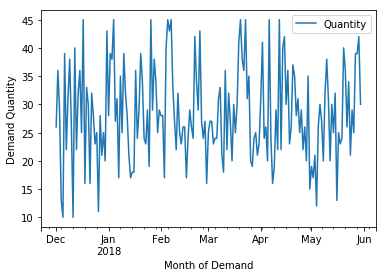

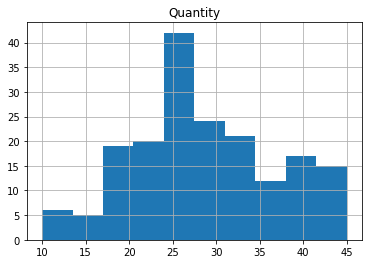

In [24]:
dataTS = df_Model[df_Model.SKU == 'SH069FA039PJONAFAMZ'][['Quantity']]
q = dataTS.Quantity.quantile(0.96)

dataTS.Quantity[dataTS.Quantity > dataTS.Quantity.quantile(0.96)] = int(q)

q = dataTS.Quantity.quantile(0.01)

dataTS.Quantity[dataTS.Quantity < dataTS.Quantity.quantile(0.01)] = int(q)

series = dataTS.copy()
ax = series.plot()
ax.set_xlabel("Month of Demand")
ax.set_ylabel("Demand Quantity")
series.hist()


#### Stationary Test using Simple Mean / Varience measures , spliting dataset into 2 halves

In [14]:
X = series.values
split = len(X) / 2
X1, X2 = X[0:int(split)+1], X[int(split):]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('Mean1=%f, Mean2=%f' % (mean1, mean2))
print('Variance1=%f, Variance2=%f' % (var1, var2))

Mean1=21.800000, Mean2=3.000000
Variance1=810.960000, Variance2=12.000000


#### Augmented Dickey-Fuller test for Stationary Test

In [19]:
from statsmodels.tsa.stattools import adfuller
X = series.values
result = adfuller(pd.DataFrame(X).iloc[:,0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


print('If ADF value is Negative and lesser then Critical values then TS is Stationary , else Non Stationary')

ADF Statistic: -7.294746
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
If ADF value is Negative and lesser then Critical values then TS is Stationary , else Non Stationary


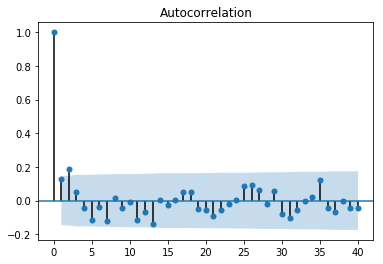

In [20]:
#from pandas.tools.plotting import autocorrelation_plot
#autocorrelation_plot(series)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series,lags=40)
print('')
#series = np.array(series, dtype=np.float64)

### ARMIA Model Building

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  181
Model:                     ARMA(4, 1)   Log Likelihood                -630.238
Method:                       css-mle   S.D. of innovations              7.813
Date:                Fri, 22 Jun 2018   AIC                           1274.476
Time:                        15:27:37   BIC                           1296.866
Sample:                             0   HQIC                          1283.554
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.5052      0.134    212.132      0.000      28.242      28.769
ar.L1.y        1.0468      0.074     14.146      0.000       0.902       1.192
ar.L2.y        0.0918      0.107      0.856      0.3

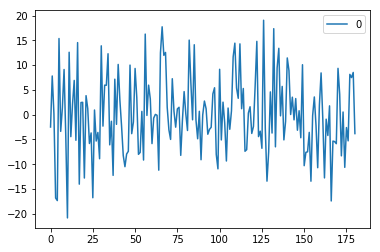

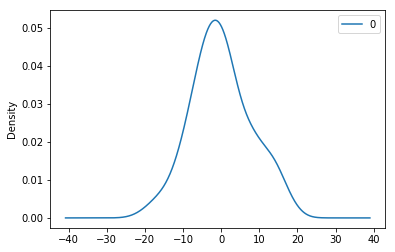

                0
count  181.000000
mean    -0.014295
std      7.901449
min    -20.850001
25%     -5.109823
50%     -0.242607
75%      5.274901
max     19.051437


In [21]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series.values, order=(4,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

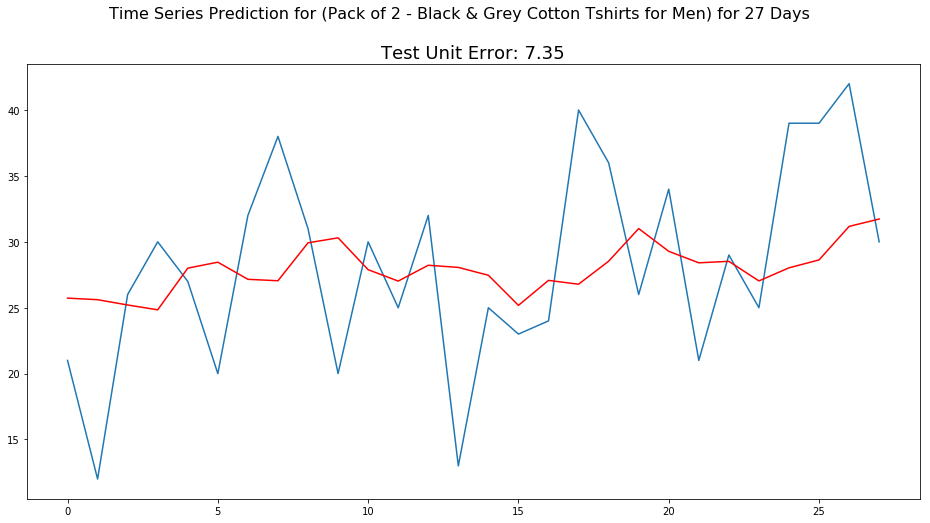

In [24]:
from sklearn.metrics import mean_squared_error
import math

X = series.values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)

tsModelErrors = {'ARIMA Model': math.sqrt(error)}

# plot
plt.figure(figsize=(16,8))
plt.suptitle('Time Series Prediction for (Pack of 2 - Black & Grey Cotton Tshirts for Men) for 27 Days', fontsize= 16)
plt.title('Test Unit Error: %.2f' % math.sqrt(error), fontsize=18)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#Pack of 2 - Black & Grey Cotton Tshirts for Men

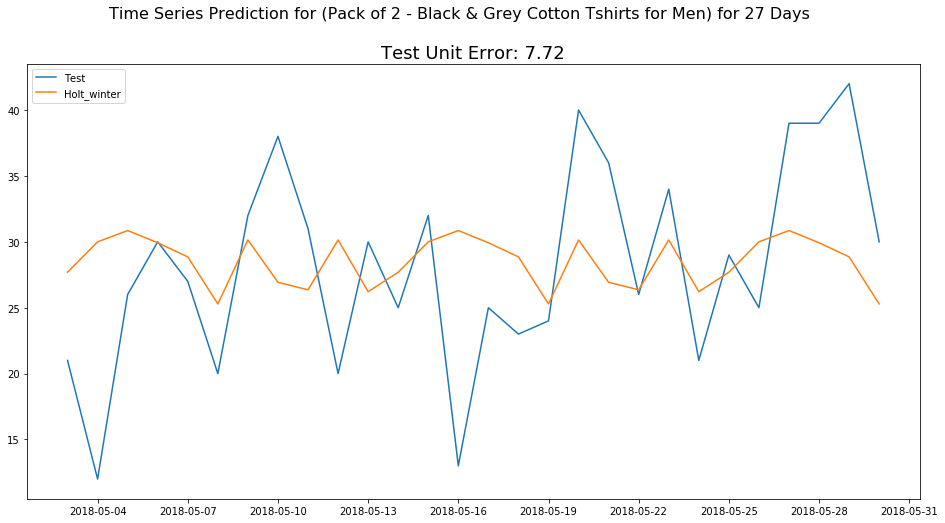

In [25]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

train_size = int(len(dataTS) * 0.85)
train, test = dataTS[0:train_size], dataTS[train_size:]
    
y_hat_avg = test.copy()

fit1 = ExponentialSmoothing(train['Quantity'].ravel(),seasonal='add',seasonal_periods=11).fit(remove_bias = True,optimized = True)
y_hat_avg['Holt_winter'] = fit1.forecast(len(test))
rms = math.sqrt(mean_squared_error(test.Quantity, y_hat_avg.Holt_winter))
tsModelErrors['Holt Winter'] = rms

plt.figure(figsize=(16,8))
#plt.plot(train['Quantity'], label='Train')
plt.suptitle('Time Series Prediction for (Pack of 2 - Black & Grey Cotton Tshirts for Men) for 27 Days', fontsize= 16)
plt.title('Test Unit Error: %.2f' % rms, fontsize=18)

plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_avg['Holt_winter'], label='Holt_winter')
plt.legend(loc='best')
plt.show()

#pd.concat([test.Quantity, y_hat_avg.Holt_winter], axis=1).reset_index()

In [33]:
from fbprophet import Prophet
dataProphet = dataTS.reset_index()
dataProphet.columns = ['ds','y']
m = Prophet(changepoint_prior_scale=0.1)
m.fit(dataProphet);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/danyal/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [36]:
future = m.make_future_dataframe(periods=10)
future.tail(10)

forecast = m.predict(future)
forecast['y'] = dataProphet.y
forecast.rename(columns={'ds': 'Date','y': 'Actual Demand','yhat': 'Prediction','yhat_lower': 'Lower Bound','yhat_upper': 'Upper Bound'}, inplace=True)
#forecast.columns = ['Date','Actual Demand','Prediction','Lower Bound','Upper Bound']
forecast[['Date','Actual Demand','Prediction','Lower Bound','Upper Bound']][154:181]

,Date,Actual Demand,Prediction,Lower Bound,Upper Bound
154,2018-05-04,12.0,28.951262,18.388837,39.434061
155,2018-05-05,26.0,27.490514,17.444836,38.281921
156,2018-05-06,30.0,31.488682,20.884328,42.647584
157,2018-05-07,27.0,26.798752,16.829629,36.749616
158,2018-05-08,20.0,27.606203,17.051913,38.619313
159,2018-05-09,32.0,29.566949,19.380299,40.113289
160,2018-05-10,38.0,27.710768,17.544165,38.545479
161,2018-05-11,31.0,28.964958,18.774787,39.694906
162,2018-05-12,20.0,27.504210,16.988031,38.213179
163,2018-05-13,30.0,31.502378,21.636546,42.319351


In [ ]:
#m.plot(forecast);
rms = math.sqrt(mean_squared_error(forecast['Actual Demand'][154:180], forecast.Prediction[154:180]))
tsModelErrors['Facebook Prophet Library'] = rms

plt.figure(figsize=(16,8))
#plt.plot(train['Quantity'], label='Train')
plt.suptitle('Time Series Prediction using FACEBOOK library for (Pack of 2 - Black & Grey Cotton Tshirts for Men) for 27 Days', fontsize= 16)
plt.title('Test Unit Error: %.2f' % rms, fontsize=18)

plt.plot(forecast['Actual Demand'][154:180], label='Test')
plt.plot(forecast['Prediction'][154:180], label='Predictions')
plt.legend(loc='best')
plt.show()

In [ ]:
m.plot_components(forecast);

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(7, 5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.bar(range(len(tsModelErrors)), list(tsModelErrors.values()), align='center')
plt.xticks(range(len(tsModelErrors)), list(tsModelErrors.keys()))
plt.title('Error Comparision between the Time Series Models', fontsize=18)

rects = ax.patches
labels = ["Unit Error = %.2f" % i for i in (tsModelErrors.values())]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')


In [ ]:
import warnings
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.8)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)